In [1]:
!pip install tsaug

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import warnings
import logging
import tsaug

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(np.__version__)

2.6.4
1.21.6


In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras

In [2]:
NUM_OF_CLASSES = 12

x = np.load('/kaggle/input/datasethw2/training_dataset_homework2/x_train.npy')

y = np.load('/kaggle/input/datasethw2/training_dataset_homework2/y_train.npy')
# Convert the sparse labels to categorical values
y_copy = y.copy()
y = tfk.utils.to_categorical(y)

In [3]:
def manualRobustScale(x):
    median_list = []
    iq_list = []

    x_s = []
    x_norm = x.copy()

    for m in range(x.shape[2]):
        x_reshaped = np.reshape(x[:,:,m], (x.shape[0]*x.shape[1]))
        median = np.median(x_reshaped)
        median_list.append(median)

        perc75 = np.percentile(x_reshaped, 75)
        perc25 = np.percentile(x_reshaped, 25)

        iq = perc75 - perc25
        iq_list.append(iq)

        x_s.append((x_reshaped - median) / iq)
        x_norm[:, :, m] = (x[:,:,m] - median) / iq
        
    return x_norm, median_list, iq_list

In [4]:
x, median, iq = manualRobustScale(x)

In [70]:
np.save('median', np.array(median))
np.save('iq', np.array(iq))

In [5]:
def educated_split(x, y):
    x_train = []
    y_train = []
    x_val = []
    y_val = []
    for i in range(NUM_OF_CLASSES):
        indices_of_class = np.where(y_copy == i)[0]
        indices_for_valid = random.sample(list(indices_of_class), round(len(indices_of_class)*0.2))
        if i == 0:
            x_train = x[list(set(indices_of_class).difference(indices_for_valid))]
            y_train = y[list(set(indices_of_class).difference(indices_for_valid))]
            x_val = x[indices_for_valid]
            y_val = y[indices_for_valid]
        else: 
            x_val = np.concatenate((x_val, x[indices_for_valid]), axis=0)
            x_train = np.concatenate((x_train, x[list(set(indices_of_class).difference(indices_for_valid))]), axis=0)
            y_val = np.concatenate((y_val, y[indices_for_valid]), axis=0)
            y_train = np.concatenate((y_train, y[list(set(indices_of_class).difference(indices_for_valid))]), axis=0)
    print(np.array(x_train).shape, np.array(x_val).shape, np.array(y_train).shape, np.array(y_val).shape)
    return np.array(x_train), np.array(x_val), np.array(y_train), np.array(y_val)

In [6]:
xtr, xv, ytr, yv = educated_split(x,y)
print(xtr.shape, xv.shape, ytr.shape, yv.shape)
print(x.shape)

(1943, 36, 6) (486, 36, 6) (1943, 12) (486, 12)
(1943, 36, 6) (486, 36, 6) (1943, 12) (486, 12)
(2429, 36, 6)


In [20]:
def mixedSlidingWindow(x, y, cat):
    xc = x.copy()
    yc = y.copy()
    max_n = max(printElementsForEachClass(cat))
    print(max_n)
    print(xc.shape, yc.shape)
    for i in range(NUM_OF_CLASSES):
        print("class "+str(i))
        starting_indices_of_class = np.where(cat == i)[0]
        num_indices_of_class = len(starting_indices_of_class)
        while num_indices_of_class < len(starting_indices_of_class)*num_oversample[i]:
            extracted = random.sample(list(starting_indices_of_class), 2)
            range_num =  random.sample(range(0, x.shape[1]), 2)
            range_num.sort()
            ranges = list(range(range_num[0], range_num[1]))
            not_ranges1 = list(range(0, range_num[0]))
            not_ranges2 = list(range(range_num[1], x.shape[1]))
            x1 = x[extracted[1]][not_ranges1]
            x2 = x[extracted[0]][ranges]
            x3 = x[extracted[1]][not_ranges2]
            xf1 = np.concatenate((x1,x2), axis=0)
            xf = np.concatenate((xf1, x3), axis=0)
            xc = np.vstack((xc,xf[None]))
            yc = np.vstack((yc,yc[extracted[0]][None]))
            num_indices_of_class += 1
    print(xc.shape, yc.shape)
    return xc, yc

In [ ]:
ytr_cat = np.argmax(ytr, axis=1)
xtrsl, ytrsl = mixedSlidingWindow(xtr, ytr, ytr_cat)
ytr_cat = np.argmax(ytrsl, axis=1)

In [8]:
def SlidingWindow(x, y, cat):
    vec_stride = [1,2,9,4,1,1,9,1,9,9,9,1]
    xc = x.copy()
    yc = y.copy()
    print(xc.shape, yc.shape)
    for i in range(NUM_OF_CLASSES):
        print("class "+str(i))
        starting_indices_of_class = np.where(cat == i)[0]

        for j in starting_indices_of_class:
            for s in range(x.shape[1]//vec_stride[i]):
                temp = np.roll(x[j],vec_stride[i]*s,axis=0)
                xc = np.vstack((xc,temp[None]))
                yc = np.vstack((yc,yc[j][None]))

    print(xc.shape, yc.shape)
    return xc, yc

In [ ]:
xtr, ytr = SlidingWindow(xtr, ytr, np.argmax(ytr, axis=1))
ytr_cat = np.argmax(ytr, axis=1)

In [ ]:
appearences = np.zeros(12)
weights = np.zeros(12)
for i in range(12):
    for j in range(2429):
        if y[j][i] == 1:
            appearences[i] += 1

print(appearences)

weights = 2429/appearences
class_weight = {0: weights[0], 1: weights[1], 2: weights[2], 3: weights[3], 4: weights[4], 5: weights[5],
                6: weights[6], 7: weights[7], 8: weights[8], 9: weights[9], 10: weights[10], 11: weights[11]}
class_weight = {0: 1, 1: 1, 2: 1, 3: 1, 4: 6, 5: 1,
                6: 1, 7: 3, 8: 1, 9: 1, 10: 1, 11: 1}
class_weight

In [7]:
def augment(x_train):
    if not isinstance(x_train, np.ndarray):
        np.array(x_train)
    my_augment = (
                tsaug.AddNoise(scale=(0.2, 0.7)) @ 0.5
                # + tsaug.TimeWarp(40) @ 0.3
                # + tsaug.Pool(size=2) @ 0.5
                )
    x_aug = []
    for i in range(x_train.shape[0]):
        temp = my_augment.augment(x_train[i])
        x_aug.append(temp)

    x_aug = np.array(x_aug)
    return x_aug

In [101]:
def oversample(x_fun, y_fun, size):
    xoversampled = x_fun.copy()
    yoversampled = np.argmax(y_fun.copy(), axis=1)
    print(xoversampled.shape, yoversampled.shape)
    for i in range(NUM_OF_CLASSES):
        indices_of_class = np.where(np.argmax(y_fun, axis=1) == i)[0]
        x_of_class = x_fun[indices_of_class]
        total_of_class = len(np.where(yoversampled == i)[0])
        iterations = 0
        while total_of_class < size and iterations < 10:
            total_of_class = len(np.where(yoversampled == i)[0])
            newx = augment(x_of_class)
            newy = np.ones(len(indices_of_class)) * i
            xoversampled = np.concatenate((xoversampled, newx),axis=0)
            yoversampled = np.append(yoversampled, newy)
            iterations += 1
    return xoversampled, tfk.utils.to_categorical(yoversampled)

In [ ]:
xov, yov = oversample(xtr, ytr, 700)

In [8]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [9]:
xtr, ytr = unison_shuffled_copies(xtr,ytr)
xtr.shape

(1943, 36, 6)

In [10]:
input_shape = x.shape[1:]
classes = y.shape[-1]
batch_size = 128
epochs = 200
input_shape, classes

((36, 6), 12)

In [11]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.LayerNormalization()(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    classifier = tfkl.Dropout(.5)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), 
                   metrics='accuracy')

    # Return the model
    return model

In [31]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 36, 256)           4864      
_________________________________________________________________
layer_normalization_3 (Layer (None, 36, 256)           512       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 18, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 18, 128)           98432     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0     

NameError: name 'visualkeras' is not defined

In [32]:
# Train the model
best_acc = 0

vec_tr_acc=[]
vec_tr_loss=[]
vec_val_acc=[]
vec_val_loss=[]

for i in range(200):
    print('iteration '+str(i)+": ")
    train = augment(xtr)
    history = model.fit(
        x = train,
        y = ytr,
        batch_size = batch_size,
        epochs = 1,
        # class_weight = class_weight,
        validation_data = (xv, yv),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
        ]
    ).history
    
    vec_tr_acc.append(history['accuracy'][0])
    vec_tr_loss.append(history['loss'][0])
    vec_val_acc.append(history['val_accuracy'][0])
    vec_val_loss.append(history['val_loss'][0])
    
    predictions = model.predict(xv)
    accuracy = accuracy_score(np.argmax(yv, axis=-1), np.argmax(predictions, axis=-1))
    if accuracy > best_acc:
        best_acc = accuracy
        best_model = tfk.models.clone_model(model)
        best_model.set_weights(model.get_weights())

iteration 0: 
16/16 [==============================] - 1s 21ms/step - loss: 2.3074 - accuracy: 0.2532 - val_loss: 1.9085 - val_accuracy: 0.3519
iteration 1: 
16/16 [==============================] - 0s 8ms/step - loss: 1.9981 - accuracy: 0.3541 - val_loss: 1.7078 - val_accuracy: 0.4280
iteration 2: 
16/16 [==============================] - 0s 11ms/step - loss: 1.8707 - accuracy: 0.3839 - val_loss: 1.5948 - val_accuracy: 0.4712
iteration 3: 
16/16 [==============================] - 0s 8ms/step - loss: 1.7838 - accuracy: 0.4215 - val_loss: 1.5517 - val_accuracy: 0.4774
iteration 4: 
16/16 [==============================] - 0s 9ms/step - loss: 1.7298 - accuracy: 0.4174 - val_loss: 1.4544 - val_accuracy: 0.4835
iteration 5: 
16/16 [==============================] - 0s 8ms/step - loss: 1.6607 - accuracy: 0.4483 - val_loss: 1.4164 - val_accuracy: 0.4897
iteration 6: 
16/16 [==============================] - 0s 8ms/step - loss: 1.6041 - accuracy: 0.4488 - val_loss: 1.3770 - val_accuracy: 0.50

In [ ]:
# dictionary of lists
dict = {'accuracy': vec_tr_acc, 'loss': vec_tr_loss, 'val_accuracy': vec_val_acc, 'val_loss': vec_val_loss}
dict

In [34]:
df = pd.DataFrame(dict) 

# saving the dataframe 
df.to_csv('twographwithaug.csv')

In [38]:
from keras import backend as K

optimizer = tf.keras.optimizers.Adam()
K.set_value(optimizer.learning_rate, 1e-3)

In [39]:
model = tfk.models.clone_model(best_model)
model.set_weights(best_model.get_weights())
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics='accuracy')

In [43]:
best_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

In [41]:
history = model.fit(
        x = xtr,
        y = ytr,
        batch_size = batch_size,
        epochs = epochs,
        # class_weight = class_weight,
        validation_data = (xv, yv),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-7)
        ]
).history

Epoch 1/200
16/16 [==============================] - 1s 17ms/step - loss: 0.5607 - accuracy: 0.8008 - val_loss: 0.8886 - val_accuracy: 0.7284
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.5167 - accuracy: 0.8111 - val_loss: 0.8958 - val_accuracy: 0.7222
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.5069 - accuracy: 0.8219 - val_loss: 0.9128 - val_accuracy: 0.7140
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.4854 - accuracy: 0.8188 - val_loss: 0.8962 - val_accuracy: 0.7140
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.4615 - accuracy: 0.8343 - val_loss: 0.9420 - val_accuracy: 0.7202
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 0.4789 - accuracy: 0.8363 - val_loss: 0.9021 - val_accuracy: 0.7140
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 0.4377 - accuracy: 0.8363 - val_loss: 0.9306 - val_accuracy: 0.7222
Epoch 8/200


In [42]:
df = pd.DataFrame(history) 

# saving the dataframe 
df.to_csv('twographnoaug.csv')

In [119]:
model.save('AAA')
# model = tfk.models.load_model('1DCNN')

In [120]:
!zip -r coseACaso.zip AAA

  adding: AAA/ (stored 0%)
  adding: AAA/keras_metadata.pb (deflated 90%)
  adding: AAA/variables/ (stored 0%)
  adding: AAA/variables/variables.index (deflated 66%)
  adding: AAA/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: AAA/saved_model.pb (deflated 87%)
  adding: AAA/assets/ (stored 0%)


In [18]:
# Predict the test set with the 1DCNN
predictions = model.predict(xv)
y_pred = np.argmax(predictions, axis=1)
predictions.shape, y_pred.shape

((486, 12), (486,))

In [19]:
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11
}
labels = ['Wish',
          'Another',
          'Comfortably',
          'Money',
          'Breathe',
          'Time',
          'Brain',
          'Echoes',
          'Wearing',
          'Sorrow',
          'Hey',
          'Shine']

Accuracy: 0.7469
Precision: 0.7664
Recall: 0.612
F1: 0.6495
Confusion Matrix
[[  4   0   0   1   0   1   1   0   0   0   0   0]
 [  0  12   0   3   0   1   3   0   0   6   0   0]
 [  0   2  52   0   0   0   0   0   0   0   0   0]
 [  0   2   0  44   1   4   1   0   0  24   0   0]
 [  0   0   0   5   0   0   0   0   0   7   0   0]
 [  0   0   0   8   0  12   0   0   0  10   0   1]
 [  0   1   0   1   0   0  58   0   0   3   0   0]
 [  0   0   0   3   0   0   0   2   0   9   0   0]
 [  0   1   0   0   0   0   0   0  22   1   0   0]
 [  0   1   0  12   0   1   4   0   0 137   0   0]
 [  0   0   0   0   0   0   0   0   0   0  15   0]
 [  0   0   0   4   0   0   0   0   0   1   0   5]]
Classification Report
              precision    recall  f1-score   support

        Wish       1.00      0.57      0.73         7
     Another       0.63      0.48      0.55        25
 Comfortably       1.00      0.96      0.98        54
       Money       0.54      0.58      0.56        76
     Breathe     

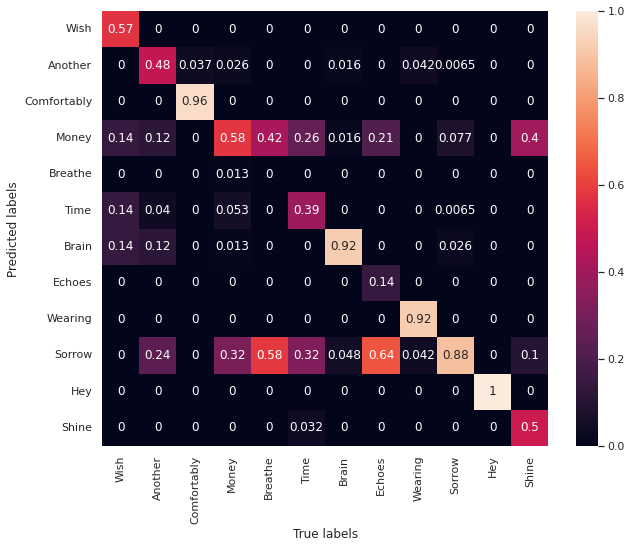

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(yv, axis=-1), np.argmax(predictions, axis=-1), normalize='true')

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(yv, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(yv, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(yv, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(yv, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

print('Confusion Matrix')
print(confusion_matrix(np.argmax(yv, axis=1), y_pred))
print('Classification Report')
print(classification_report(np.argmax(yv, axis=1), y_pred, target_names=labels))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.set(font_scale=1)
sns.heatmap(cm.T, xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()),annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Damn, once again no free lunch